In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Move all constants to the top
PORTAL_LAUNCH_DATE = '2018-01-01'
ANALYSIS_END_YEAR = 2025
PRICE_SEGMENTS = [0, 400000, 600000, 800000, float('inf')]
PRICE_LABELS = ['Low (<400k)', 'Mid (400-600k)', 'High (600-800k)', 'Premium (>800k)']

In [3]:
# data path
file_cea = './data/raw/CEASalespersonsPropertyTransactionRecordsresidential.csv'
file_price = './data/raw/Resale flat prices based on registration date from Jan-2017 onwards.csv'

In [4]:
# load data
df_cea = pd.read_csv(file_cea)
df_price = pd.read_csv(file_price)

# data cleaning

In [5]:
# # remove salesperson_reg_num == '-'
df_cea = df_cea[df_cea['salesperson_reg_num'] != '-']

# use salesperson_reg_num as unique identifier
# drop district & general_location as no useful information
df_cea = df_cea.drop(columns=['salesperson_name', 'district', 'general_location'])

# keep property_type = 'HDB'
df_cea = df_cea[df_cea['property_type'] == 'HDB']

# only focus on transaction_type = 'RESALE' 
df_cea = df_cea[df_cea['transaction_type'] == 'RESALE']

# format to datetime 
df_cea['transaction_date'] = pd.to_datetime(df_cea['transaction_date'], format='%b-%Y')

# format to datetime 
df_price['date'] = pd.to_datetime(df_price['month'], format='%Y-%m')

# Transaction Volume Comparison: Before vs After

In [6]:
# Set up plotting style
# plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

df_price['year'] = df_price['date'].dt.year
df_cea['year'] = df_cea['transaction_date'].dt.year 

df_hdb = df_price.copy()

# Ensure date column is datetime
df_hdb['date'] = pd.to_datetime(df_hdb['date'])

# Create year-month column for grouping
df_hdb['year_month'] = df_hdb['date'].dt.to_period('M')
df_cea['year_month'] = df_cea['transaction_date'].dt.to_period('M')

# Define portal launch date
portal_launch = pd.to_datetime(PORTAL_LAUNCH_DATE)

# Create pre/post portal indicator
df_hdb['post_portal'] = df_hdb['date'] >= portal_launch
df_cea['post_portal'] = df_cea['transaction_date'] >= portal_launch

In [7]:
# volume change of total transactions

# Monthly transaction counts
monthly_transactions = df_hdb.groupby('year_month').size().reset_index(name='transaction_count')
monthly_transactions['date'] = monthly_transactions['year_month'].dt.to_timestamp()
monthly_transactions['year'] = monthly_transactions['date'].dt.year
monthly_transactions['month'] = monthly_transactions['date'].dt.month
monthly_transactions['post_portal'] = monthly_transactions['date'] >= portal_launch

# Calculate pre and post portal averages
pre_portal_monthly = monthly_transactions[~monthly_transactions['post_portal']]
post_portal_monthly = monthly_transactions[monthly_transactions['post_portal']]

pre_portal_avg = pre_portal_monthly['transaction_count'].mean()
post_portal_avg = post_portal_monthly['transaction_count'].mean()

print(f"Average monthly transactions BEFORE portal (2017): {pre_portal_avg:.0f}")
print(f"Average monthly transactions AFTER portal (2018+): {post_portal_avg:.0f}")
print(f"Change: {((post_portal_avg - pre_portal_avg) / pre_portal_avg * 100):+.1f}%")

Average monthly transactions BEFORE portal (2017): 1709
Average monthly transactions AFTER portal (2018+): 2105
Change: +23.2%


In [8]:
# agent volume
df_cea_seller = df_cea[df_cea.represented == 'SELLER']
df_cea_buyer = df_cea[df_cea.represented == 'BUYER']

# seller
# Monthly agent-represented HDB transactions
monthly_agent = df_cea_seller.groupby('year_month').size().reset_index(name='agent_transactions')
monthly_agent['date'] = monthly_agent['year_month'].dt.to_timestamp()
monthly_agent['post_portal'] = monthly_agent['date'] >= portal_launch

# Calculate pre and post portal averages
pre_portal_monthly = monthly_agent[~monthly_agent['post_portal']]
post_portal_monthly = monthly_agent[monthly_agent['post_portal']]

pre_portal_avg = pre_portal_monthly['agent_transactions'].mean()
post_portal_avg = post_portal_monthly['agent_transactions'].mean()

print(f"Average monthly transactions BEFORE portal (2017): {pre_portal_avg:.0f}")
print(f"Average monthly transactions AFTER portal (2018+): {post_portal_avg:.0f}")
print(f"Change: {((post_portal_avg - pre_portal_avg) / pre_portal_avg * 100):+.1f}%")


Average monthly transactions BEFORE portal (2017): 1556
Average monthly transactions AFTER portal (2018+): 1987
Change: +27.7%


In [9]:
# buyer
# Monthly agent-represented HDB transactions
monthly_agent = df_cea_buyer.groupby('year_month').size().reset_index(name='agent_transactions')
monthly_agent['date'] = monthly_agent['year_month'].dt.to_timestamp()
monthly_agent['post_portal'] = monthly_agent['date'] >= portal_launch

# Calculate pre and post portal averages
pre_portal_monthly = monthly_agent[~monthly_agent['post_portal']]
post_portal_monthly = monthly_agent[monthly_agent['post_portal']]

pre_portal_avg = pre_portal_monthly['agent_transactions'].mean()
post_portal_avg = post_portal_monthly['agent_transactions'].mean()

print(f"Average monthly transactions BEFORE portal (2017): {pre_portal_avg:.0f}")
print(f"Average monthly transactions AFTER portal (2018+): {post_portal_avg:.0f}")
print(f"Change: {((post_portal_avg - pre_portal_avg) / pre_portal_avg * 100):+.1f}%")


Average monthly transactions BEFORE portal (2017): 1041
Average monthly transactions AFTER portal (2018+): 1275
Change: +22.5%


In [10]:
# Merge the data
monthly_combined = pd.merge(monthly_transactions, monthly_agent, on=['year_month', 'date', 'post_portal'], how='left')
monthly_combined['agent_transactions'] = monthly_combined['agent_transactions'].fillna(0)
monthly_combined['agent_representation_rate'] = (monthly_combined['agent_transactions'] / 
                                                monthly_combined['transaction_count'] * 100)
monthly_combined['direct_transactions'] = (monthly_combined['transaction_count'] - 
                                            monthly_combined['agent_transactions'])
monthly_combined['direct_rate'] = (monthly_combined['direct_transactions'] / 
                                    monthly_combined['transaction_count'] * 100)

In [11]:

# Calculate monthly averages for pre and post periods
pre_portal_monthly = monthly_combined[~monthly_combined['post_portal']]
post_portal_monthly = monthly_combined[monthly_combined['post_portal']]

pre_stats = {
    'avg_agent_rate': pre_portal_monthly['agent_representation_rate'].mean(),
    'avg_direct_rate': pre_portal_monthly['direct_rate'].mean(),
}

    
post_stats = {
    'avg_agent_rate': post_portal_monthly['agent_representation_rate'].mean(),
    'avg_direct_rate': post_portal_monthly['direct_rate'].mean(),
}
    
print(f"PRE-PORTAL PERIOD :")
print(f"   • Average agent representation rate: {pre_stats['avg_agent_rate']:.1f}%")
print(f"   • Average direct transaction rate: {pre_stats['avg_direct_rate']:.1f}%")

print(f"\nPOST-PORTAL PERIOD :")
print(f"   • Average agent representation rate: {post_stats['avg_agent_rate']:.1f}%")
print(f"   • Average direct transaction rate: {post_stats['avg_direct_rate']:.1f}%")
    
agent_rate_change = post_stats['avg_agent_rate'] - pre_stats['avg_agent_rate']
print(f" \n Agent representation rate change: {agent_rate_change:+.1f}%")

agent_rate_change = post_stats['avg_direct_rate'] - pre_stats['avg_direct_rate']
print(f"  \n direct transaction rate change: {agent_rate_change:+.1f}%")

PRE-PORTAL PERIOD :
   • Average agent representation rate: 63.2%
   • Average direct transaction rate: 36.8%

POST-PORTAL PERIOD :
   • Average agent representation rate: 64.1%
   • Average direct transaction rate: 35.9%
 
 Agent representation rate change: +0.9%
  
 direct transaction rate change: -0.9%


In [12]:
# CEA agent data contains two types of represents: SELLER, BUYER
# if we include both, it may cause duplicated transactions
# so we split the data into different represents


# 2025 data is incomplete, only 7 months, so remove the data point
data_seller = df_cea[(df_cea['year'] < ANALYSIS_END_YEAR) & 
              (df_cea['represented'] == 'SELLER')].year.value_counts().sort_index()

data_buyer = df_cea[(df_cea['year'] < ANALYSIS_END_YEAR) & 
              (df_cea['represented'] == 'BUYER')].year.value_counts().sort_index()

In [13]:
# get all transactions including self transactions
data_all = df_price[(df_price['year'] < ANALYSIS_END_YEAR)].year.value_counts().sort_index()

In [14]:
def plot(data, represent, cutoff): 
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))

    # set colors
    colors = []
    for date in data.index:
        if date == 2017:
            colors.append('red')
        elif date in [2019, 2020]:
            colors.append('yellow')
        else:
            colors.append('green')


    sns.lineplot(x=data.index, y=data.values, marker='o', markersize=8, linewidth=2)
    sns.lineplot(x=data_all.index, y=data_all.values, marker='x', markersize=2, linewidth=1)
    plt.scatter(data.index, data.values, c=colors, s=100, zorder=5, edgecolors='black', linewidth=1)

    plt.axhline(y=cutoff, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (34,000)')

    plt.title(f'Transaction Volume Trends ({represent}): 2017 vs 2018+', fontsize=16)
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('Transaction Volume', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

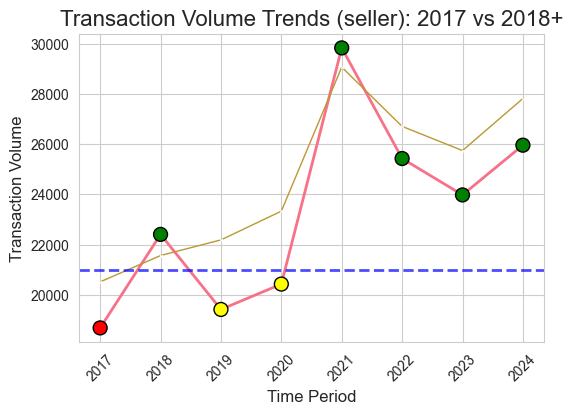

In [15]:
plot(data_seller, 'seller', cutoff=21000)

# it is suspicious that even in the seller CEA transaction data, 2018, 2021 volume are higher than whole market transation numbers. 

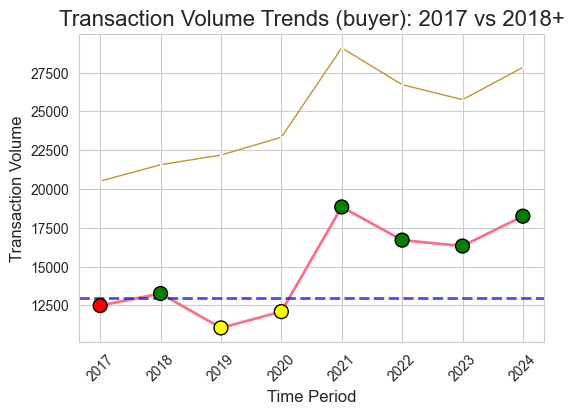

In [16]:
plot(data_buyer, 'buyer', 13000)

# Market share change: Before vs After

In [17]:
# market share
market_share = pd.DataFrame({
    'Total_Market': data_all,
    'Agent_buyer': data_buyer,
    'Agent_seller': data_seller,
}).fillna(0)

market_share['Agent_Market_Share_Pct_buyer'] = (
    market_share['Agent_buyer'] / market_share['Total_Market'] * 100
)

market_share['Agent_Market_Share_Pct_seller'] = (
    market_share['Agent_seller'] / market_share['Total_Market'] * 100
)

# comparison, exclude 2019, 2020, 2025
pre_portal_share = market_share[market_share.index == 2017]['Agent_Market_Share_Pct_seller'].iloc[0]
post_portal_share = market_share[market_share.index.isin([2018,2021,2022,2023,2024])]['Agent_Market_Share_Pct_seller'].mean()

share_decline = pre_portal_share - post_portal_share

print("=== Comparison Seller ===")
print(f"Before: {pre_portal_share:.1f}%")
print(f"After: {post_portal_share:.1f}%")
print(f"Diff: {share_decline:.1f}%")

pre_portal_share = market_share[market_share.index == 2017]['Agent_Market_Share_Pct_buyer'].iloc[0]
post_portal_share = market_share[market_share.index.isin([2018,2021,2022,2023,2024])]['Agent_Market_Share_Pct_buyer'].mean()

share_decline = pre_portal_share - post_portal_share

print("=== Comparison Buyer ===")
print(f"Before: {pre_portal_share:.1f}%")
print(f"After: {post_portal_share:.1f}%")
print(f"Diff: {share_decline:.1f}%")


=== Comparison Seller ===
Before: 91.0%
After: 97.6%
Diff: -6.6%
=== Comparison Buyer ===
Before: 60.9%
After: 63.6%
Diff: -2.7%


# (Indirect Analysis) Resale price changes comparison: Before vs After 

=== Before ===
   year    price_segment  Transaction_Count  Average_Price
0  2017      Low (<400k)               9584       328231.0
1  2017   Mid (400-600k)               7962       476234.0
2  2017  High (600-800k)               2299       686443.0
3  2017  Premium (>800k)                664       885593.0

=== After ===
    year    price_segment  Transaction_Count  Average_Price
4   2018      Low (<400k)              10434       321506.0
5   2018   Mid (400-600k)               7894       477665.0
6   2018  High (600-800k)               2399       687109.0
7   2018  Premium (>800k)                834       888278.0
8   2019      Low (<400k)              11152       316822.0
9   2019   Mid (400-600k)               8007       480233.0
10  2019  High (600-800k)               2359       684366.0
11  2019  Premium (>800k)                668       890077.0
12  2020      Low (<400k)               9913       320790.0
13  2020   Mid (400-600k)               9820       483263.0
14  2020  High 

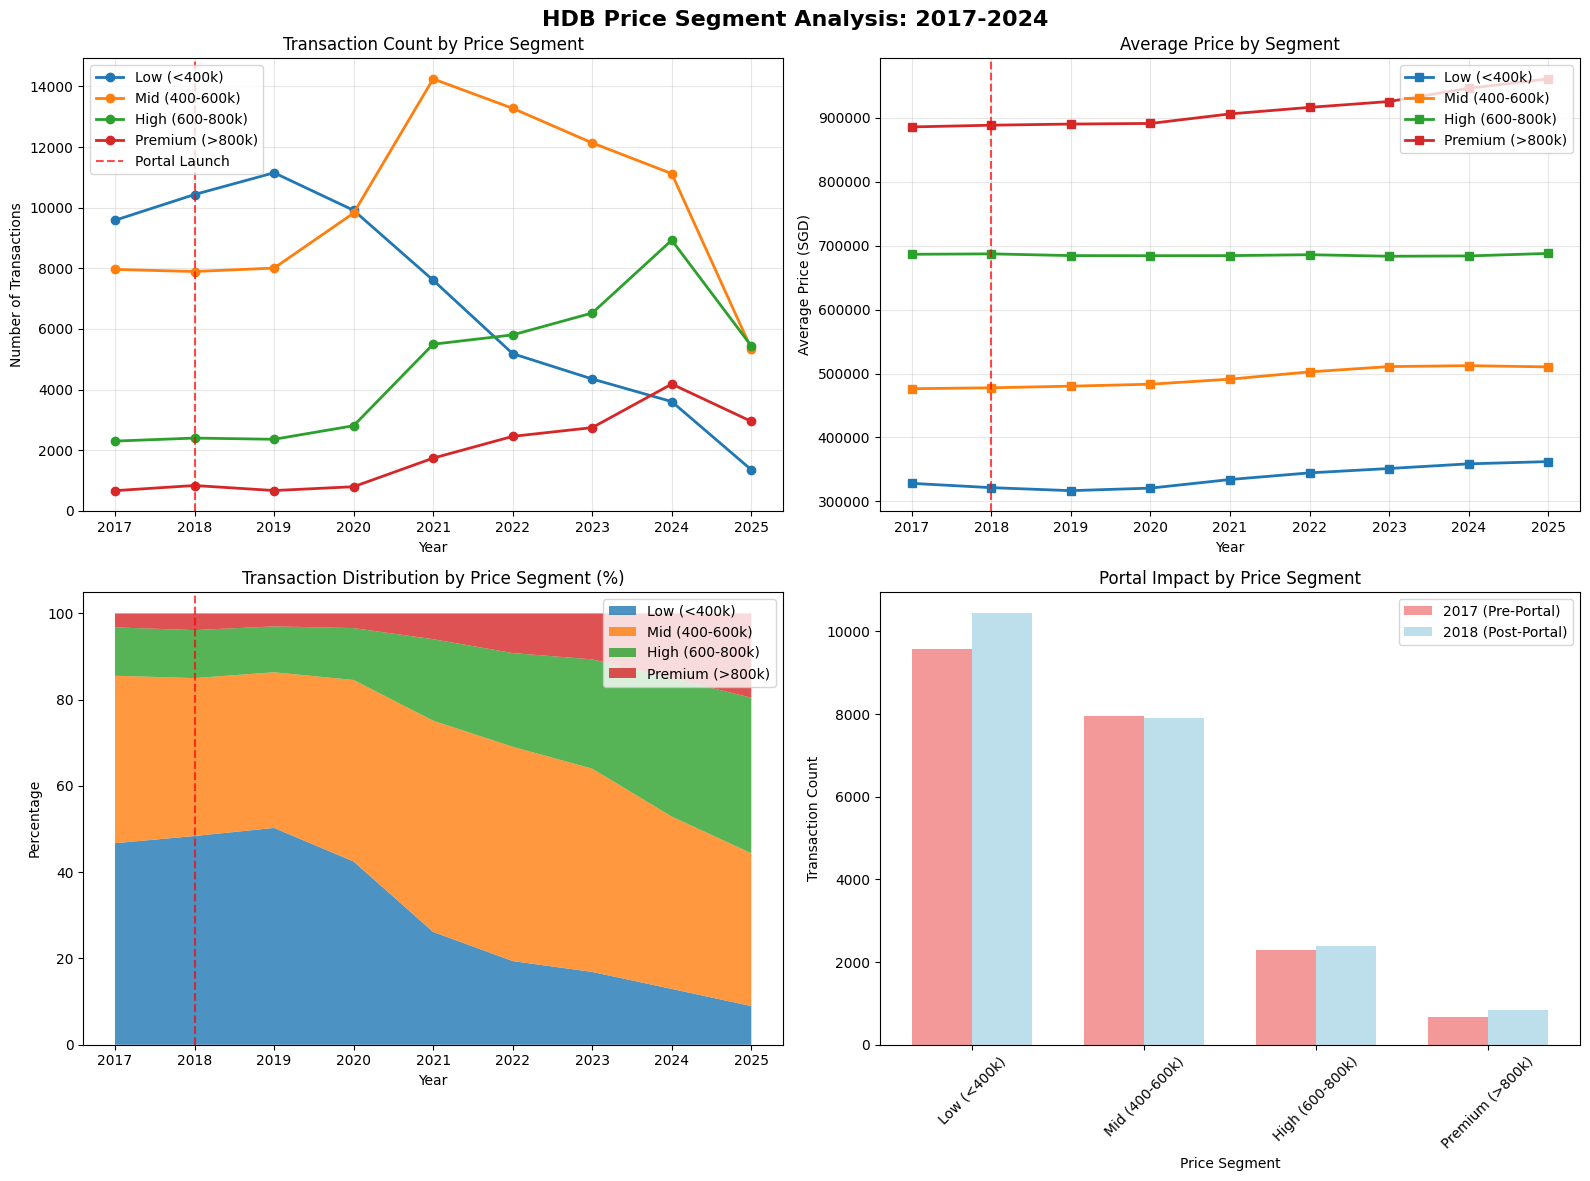

In [18]:
def analyze_price_segment_trends_over_time(df_price):
    df_price['price_segment'] = pd.cut(df_price['resale_price'], 
                                      bins=PRICE_SEGMENTS,
                                      labels=PRICE_LABELS)
    
    price_segment_trends = df_price.groupby(['year', 'price_segment']).agg({
        'resale_price': ['count', 'mean']
    }).round(0)
    
    price_segment_trends.columns = ['Transaction_Count', 'Average_Price']
    price_segment_trends = price_segment_trends.reset_index()
    
    # before
    trends_before_2018 = price_segment_trends[price_segment_trends['year'] < 2018]
    trends_2018_onwards = price_segment_trends[price_segment_trends['year'] >= 2018]  
    
    print("=== Before ===")
    print(trends_before_2018)
    
    print("\n=== After ===")
    print(trends_2018_onwards)
    
    # compare
    comparison_analysis = compare_pre_post_portal_by_segment(price_segment_trends)
    
    return price_segment_trends, trends_before_2018, trends_2018_onwards, comparison_analysis

def compare_pre_post_portal_by_segment(trends_df):
    df_2017 = trends_df[trends_df['year'] == 2017].set_index('price_segment')
    df_2018 = trends_df[trends_df['year'] == 2018].set_index('price_segment')
    
    comparison = pd.DataFrame({
        'Count_2017': df_2017['Transaction_Count'],
        'Count_2018': df_2018['Transaction_Count'],
        'AvgPrice_2017': df_2017['Average_Price'],
        'AvgPrice_2018': df_2018['Average_Price']
    }).fillna(0)
    
    comparison['Count_Change_Pct'] = (
        (comparison['Count_2018'] - comparison['Count_2017']) / comparison['Count_2017'] * 100
    ).round(1)
    
    comparison['Price_Change_Pct'] = (
        (comparison['AvgPrice_2018'] - comparison['AvgPrice_2017']) / comparison['AvgPrice_2017'] * 100
    ).round(1)
    
    print("\n=== Comparison ===")
    print(comparison)
    
    return comparison


def visualize_price_segment_trends(trends_df):
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('HDB Price Segment Analysis: 2017-2024', fontsize=16, fontweight='bold')
    
    # volume
    pivot_count = trends_df.pivot(index='year', columns='price_segment', values='Transaction_Count')
    
    axes[0,0].plot(pivot_count.index, pivot_count.values, marker='o', linewidth=2)
    axes[0,0].axvline(x=2018, color='red', linestyle='--', alpha=0.7, label='HDB Portal Launch')
    axes[0,0].set_title('Transaction Count by Price Segment')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend(pivot_count.columns.tolist() + ['Portal Launch'])
    axes[0,0].grid(True, alpha=0.3)
    
    # price
    pivot_price = trends_df.pivot(index='year', columns='price_segment', values='Average_Price')
    
    axes[0,1].plot(pivot_price.index, pivot_price.values, marker='s', linewidth=2)
    axes[0,1].axvline(x=2018, color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_title('Average Price by Segment')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Average Price (SGD)')
    axes[0,1].legend(pivot_price.columns)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. distribution
    pivot_count_pct = pivot_count.div(pivot_count.sum(axis=1), axis=0) * 100
    
    axes[1,0].stackplot(pivot_count_pct.index, pivot_count_pct.T, 
                       labels=pivot_count_pct.columns, alpha=0.8)
    axes[1,0].axvline(x=2018, color='red', linestyle='--', alpha=0.7)
    axes[1,0].set_title('Transaction Distribution by Price Segment (%)')
    axes[1,0].set_xlabel('Year')
    axes[1,0].set_ylabel('Percentage')
    axes[1,0].legend(loc='upper right')
    
    # 4. comparison
    pre_portal = trends_df[trends_df['year'] == 2017].set_index('price_segment')['Transaction_Count']
    post_portal = trends_df[trends_df['year'] == 2018].set_index('price_segment')['Transaction_Count']
    
    x = range(len(pre_portal))
    width = 0.35
    
    axes[1,1].bar([i - width/2 for i in x], pre_portal.values, width, 
                 label='2017 (Pre-Portal)', alpha=0.8, color='lightcoral')
    axes[1,1].bar([i + width/2 for i in x], post_portal.values, width, 
                 label='2018 (Post-Portal)', alpha=0.8, color='lightblue')
    
    axes[1,1].set_title('Portal Impact by Price Segment')
    axes[1,1].set_xlabel('Price Segment')
    axes[1,1].set_ylabel('Transaction Count')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(pre_portal.index, rotation=45)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()


df_hdb = df_price.copy()  
all_trends, before_2018, after_2018, comparison = analyze_price_segment_trends_over_time(df_hdb)
visualize_price_segment_trends(all_trends)

# (Indirect Analysis) HDB Room Type Changes

In [19]:
def analyze_flat_type(df_price):
    price_segment_trends = df_price.groupby(['year', 'flat_type']).agg({
        'flat_type': ['count']
    }).round(0)

    price_segment_trends.columns = ['Transaction_Count']
    price_segment_trends = price_segment_trends.reset_index()

    # before
    trends_before_2018 = price_segment_trends[price_segment_trends['year'] < 2018]
    trends_2018_onwards = price_segment_trends[price_segment_trends['year'] >= 2018]  

    print("=== Before ===")
    print(trends_before_2018)

    print("\n=== After ===")
    print(trends_2018_onwards)

    # compare
    comparison_analysis = compare_pre_post_portal_by_segment(price_segment_trends)
    
    return price_segment_trends, trends_before_2018, trends_2018_onwards, comparison_analysis 



=== Before ===
   year         flat_type  Transaction_Count
0  2017            1 ROOM                  9
1  2017            2 ROOM                219
2  2017            3 ROOM               5047
3  2017            4 ROOM               8604
4  2017            5 ROOM               5002
5  2017         EXECUTIVE               1624
6  2017  MULTI-GENERATION                  4

=== After ===
    year         flat_type  Transaction_Count
7   2018            1 ROOM                  9
8   2018            2 ROOM                286
9   2018            3 ROOM               5119
10  2018            4 ROOM               8769
11  2018            5 ROOM               5487
12  2018         EXECUTIVE               1876
13  2018  MULTI-GENERATION                 15
14  2019            1 ROOM                 11
15  2019            2 ROOM                414
16  2019            3 ROOM               5423
17  2019            4 ROOM               9228
18  2019            5 ROOM               5427
19  2019    

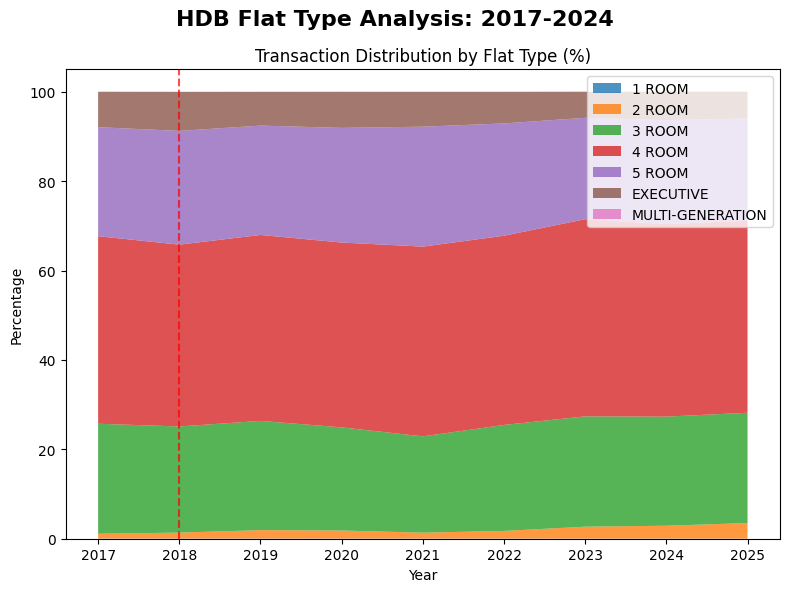

In [20]:

def compare_pre_post_portal_by_segment(trends_df):
    df_2017 = trends_df[trends_df['year'] == 2017].set_index('flat_type')
    df_2018 = trends_df[trends_df['year'] == 2018].set_index('flat_type')
    
    comparison = pd.DataFrame({
        'Count_2017': df_2017['Transaction_Count'],
        'Count_2018': df_2018['Transaction_Count']
    }).fillna(0)
    
    comparison['Count_Change_Pct'] = (
        (comparison['Count_2018'] - comparison['Count_2017']) / comparison['Count_2017'] * 100
    ).round(1)
    
    print("\n=== Comparison ===")
    print(comparison)
    
    return comparison

def visualize_price_segment_trends(trends_df):
    plt.style.use('default')
    fig, axes = plt.subplots(figsize=(8, 6))
    fig.suptitle('HDB Flat Type Analysis: 2017-2024', fontsize=16, fontweight='bold')
    
    # volume
    pivot_count = trends_df.pivot(index='year', columns='flat_type', values='Transaction_Count')
    
    # 3. distribution
    pivot_count_pct = pivot_count.div(pivot_count.sum(axis=1), axis=0) * 100
    
    axes.stackplot(pivot_count_pct.index, pivot_count_pct.T, 
                       labels=pivot_count_pct.columns, alpha=0.8)
    axes.axvline(x=2018, color='red', linestyle='--', alpha=0.7)
    axes.set_title('Transaction Distribution by Flat Type (%)')
    axes.set_xlabel('Year')
    axes.set_ylabel('Percentage')
    axes.legend(loc='upper right')
    
    
    plt.tight_layout()
    plt.show()


df_hdb = df_price.copy()  
all_trends, before_2018, after_2018, comparison = analyze_flat_type(df_hdb)
visualize_price_segment_trends(all_trends)

# Location Changes

In [21]:
def analyze_geographic_impact(df_price, df_cea):
    
    hdb_town_volume = df_hdb.groupby(['town', df_hdb['year'] >= 2018]).size().unstack(fill_value=0)
    cea_town_volume = df_cea[df_cea.represented == 'SELLER'].groupby(['town', df_cea['transaction_date'] >= pd.to_datetime(PORTAL_LAUNCH_DATE)]).size().unstack(fill_value=0)
    
    town_analysis = pd.DataFrame({
        'HDB_Pre': hdb_town_volume.get(False, 0),
        'HDB_Post': hdb_town_volume.get(True, 0),
        'CEA_Pre': cea_town_volume.get(False, 0),
        'CEA_Post': cea_town_volume.get(True, 0)
    }).fillna(0)
    
    town_analysis['Agent_Share_Pre'] = (town_analysis['CEA_Pre'] / town_analysis['HDB_Pre'] * 100).round(1)
    town_analysis['Agent_Share_Post'] = (town_analysis['CEA_Post'] / town_analysis['HDB_Post'] * 100).round(1)
    town_analysis['Share_Change'] = town_analysis['Agent_Share_Post'] - town_analysis['Agent_Share_Pre']
    
    print("=== Market Share Changes ===")
    print(town_analysis.sort_values('Share_Change'))
    
    return town_analysis

town_analysis = analyze_geographic_impact(df_price, df_cea)

=== Market Share Changes ===
                 HDB_Pre  HDB_Post  CEA_Pre  CEA_Post  Agent_Share_Pre  \
town                                                                     
CENTRAL AREA         182      1479      180      1354             98.9   
HOUGANG              980      9705      954      8989             97.3   
SEMBAWANG            525      5790      498      5355             94.9   
ANG MO KIO           942      7736      891      7139             94.6   
CLEMENTI             438      4257      421      4031             96.1   
CHOA CHU KANG        804      8823      776      8483             96.5   
YISHUN              1257     13219     1191     12551             94.7   
SENGKANG            1534     15881     1450     15195             94.5   
TAMPINES            1299     13124     1198     12288             92.2   
BEDOK               1148      9917     1061      9300             92.4   
SERANGOON            430      3350      389      3083             90.5   
BUKIT PAN

In [22]:
town_analysis = town_analysis.reset_index()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sg = world[world['name'] == 'Singapore']

towns = gpd.read_file('./data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson') 

from bs4 import BeautifulSoup

def getTownName(html): 
    soup = BeautifulSoup(html, "html.parser")
    table = soup.find("table")

    data = []
    for tr in table.find_all("tr"):
        if tr.find("em"):
            continue
        th = tr.find("th")
        td = tr.find("td")
        if th and td:
            key = th.get_text(strip=True)
            value = td.get_text(strip=True)
            if key == 'PLN_AREA_N': 
                return value
    return ''

towns['town'] = towns.Description.map(getTownName)


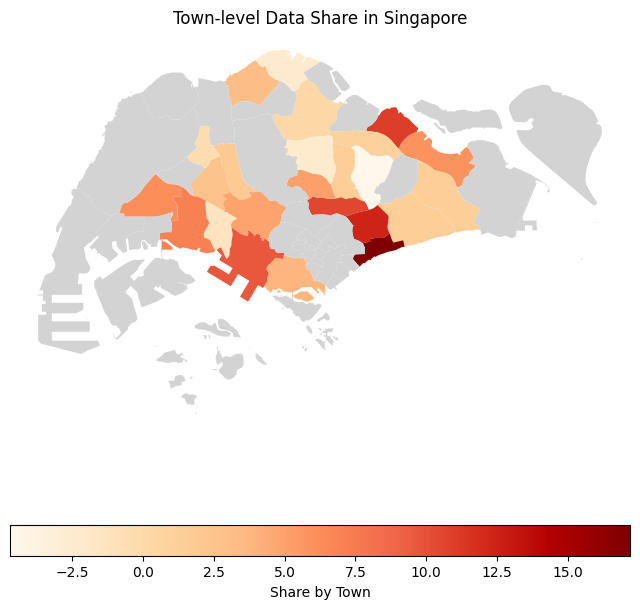

In [23]:

gdf = towns.merge(town_analysis, on='town', how='left')  

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sg.boundary.plot(ax=ax, color='black')  
gdf.plot(column='Share_Change', ax=ax, legend=True,
         cmap='OrRd', missing_kwds={'color': 'lightgrey'},
         legend_kwds={'label': 'Share by Town', 'orientation': 'horizontal'})
ax.set_title('Town-level Data Share in Singapore')
ax.axis('off')
plt.show()
